In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


# Data Loading and Cleaning

In [2]:
df=pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.shape


(50000, 2)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

In [5]:
import re
stop_words = set([
    'the', 'and', 'is', 'in', 'it', 'of', 'to', 'this', 'that', 'was', 'for', 'with', 'as',
    'on', 'but', 'are', 'not', 'you', 'i', 'have', 'be', 'they', 'he', 'she', 'we', 'an', 'at'
])

# Clean text function
def clean_text(text):
    text = text.lower()
    text = re.sub('<.*?>', '', text)              
    text = re.sub(r'[^a-z\s]', '', text)          
    text = ' '.join([word for word in text.split() if word not in stop_words])  
    return text

# Apply cleaning
df['clean_review'] = df['review'].apply(clean_text)

In [6]:
# Check for nulls and duplicates
print("Null values:\n", df.isnull().sum())
print("Duplicate entries:", df.duplicated().sum())


Null values:
 review          0
sentiment       0
clean_review    0
dtype: int64
Duplicate entries: 418


In [7]:
df = df.drop_duplicates()

# EDA

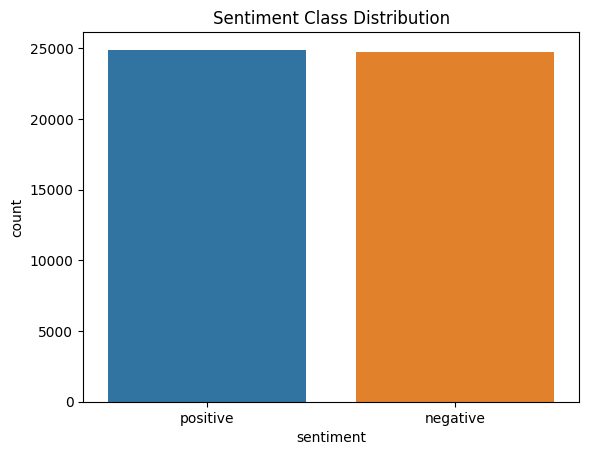

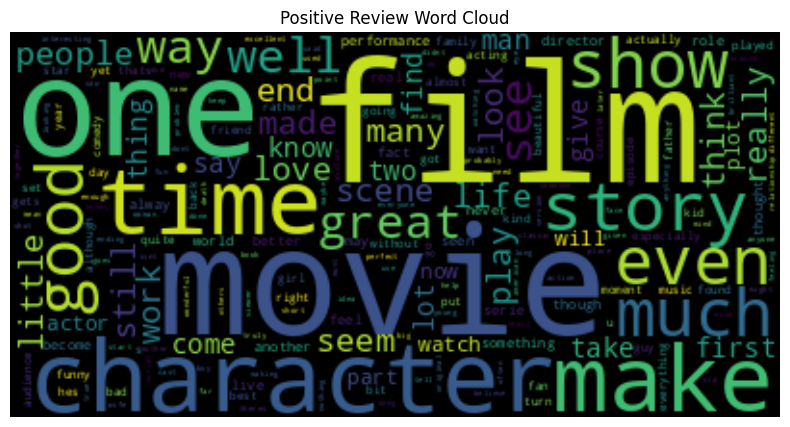

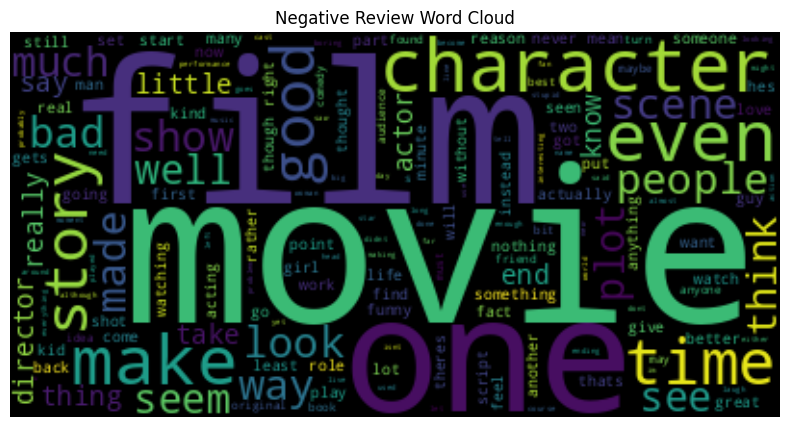

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


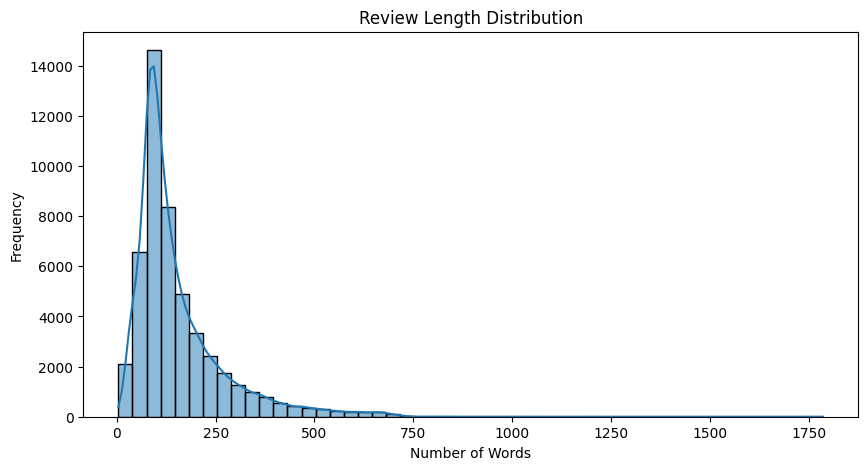

Top 15 Positive Words: [('a', 161858), ('film', 39303), ('movie', 35860), ('his', 33435), ('one', 25630), ('its', 24810), ('by', 23440), ('all', 21754), ('who', 21426), ('from', 20642), ('her', 19041), ('has', 17848), ('so', 17170), ('like', 17001), ('about', 16162)]
Top 15 Negative Words: [('a', 155182), ('movie', 47055), ('film', 34686), ('one', 24380), ('his', 23449), ('its', 22756), ('all', 22449), ('like', 21515), ('so', 21081), ('just', 20577), ('by', 20183), ('or', 19653), ('from', 19185), ('who', 18398), ('if', 17907)]


In [8]:
# Class distribution
sns.countplot(data=df, x='sentiment')
plt.title("Sentiment Class Distribution")
plt.show()

# Word Clouds
positive_reviews = ' '.join(df[df['sentiment'] == 'positive']['clean_review'])
negative_reviews = ' '.join(df[df['sentiment'] == 'negative']['clean_review'])

plt.figure(figsize=(10, 5))
WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.imshow(WordCloud().generate(positive_reviews), interpolation='bilinear')
plt.title("Positive Review Word Cloud")
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(WordCloud(background_color='black').generate(negative_reviews), interpolation='bilinear')
plt.title("Negative Review Word Cloud")
plt.axis('off')
plt.show()

# Review Length Distribution
df['review_length'] = df['clean_review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Most common words (optional)
positive_words = Counter(" ".join(df[df['sentiment'] == 'positive']['clean_review']).split()).most_common(15)
negative_words = Counter(" ".join(df[df['sentiment'] == 'negative']['clean_review']).split()).most_common(15)

print("Top 15 Positive Words:", positive_words)
print("Top 15 Negative Words:", negative_words)

# Tokenization & padding

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

df_small=df.sample(n=10000, random_state=42).reset_index(drop=True)

# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_small['clean_review'])
sequences = tokenizer.texts_to_sequences(df_small['clean_review'])

# Pad sequences
maxlen = 200
X = pad_sequences(sequences, maxlen=maxlen)

# Labels: convert positive -> 1, negative -> 0
y = df_small['sentiment'].map({'positive': 1, 'negative': 0}).values

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Model Building: RNN / LSTM / GRU

In [10]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=10000, output_dim=64))
rnn_model.add(SimpleRNN(64))
rnn_model.add(Dense(1, activation='sigmoid'))


rnn_model.build(input_shape=(None, maxlen))

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn_model.summary()

rnn_history = rnn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 648,321 (2.47 MB)

 Trainable params: 648,321 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.4943 - loss: 0.6962 - val_accuracy: 0.5106 - val_loss: 0.6816
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.7750 - loss: 0.5187 - val_accuracy: 0.7444 - val_loss: 0.5401
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9560 - loss: 0.1617 - val_accuracy: 0.7625 - val_loss: 0.5743
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9986 - loss: 0.0207 - val_accuracy: 0.7094 - val_loss: 0.7585
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.7831 - val_loss: 0.7027


**LSTM**

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=10000, output_dim=64))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.build(input_shape=(None, maxlen))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

lstm_history = lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 200, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 673,089 (2.57 MB)

 Trainable params: 673,089 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.6132 - loss: 0.6370 - val_accuracy: 0.8244 - val_loss: 0.3968
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.8923 - loss: 0.2825 - val_accuracy: 0.8431 - val_loss: 0.3620
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.9478 - loss: 0.1492 - val_accuracy: 0.8313 - val_loss: 0.4296
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.9771 - loss: 0.0777 - val_accuracy: 0.8369 - val_loss: 0.4872
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.9817 - loss: 0.0517 - val_accuracy: 0.8338 - val_loss: 0.6198


**GRU**

In [12]:
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense

gru_model = Sequential()
gru_model.add(Embedding(input_dim=10000, output_dim=64))
gru_model.add(GRU(64))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.build(input_shape=(None, maxlen))
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gru_model.summary()


gru_history = gru_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 200, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 665,025 (2.54 MB)

 Trainable params: 665,025 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.5731 - loss: 0.6595 - val_accuracy: 0.8188 - val_loss: 0.4096
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.8816 - loss: 0.2839 - val_accuracy: 0.8194 - val_loss: 0.3920
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9526 - loss: 0.1454 - val_accuracy: 0.8075 - val_loss: 0.4275
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.9752 - loss: 0.0896 - val_accuracy: 0.8131 - val_loss: 0.5606
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9876 - loss: 0.0435 - val_accuracy: 0.7987 - val_loss: 0.6549


# Observation:

LSTM performed best overall on validation accuracy and loss.

RNN underperformed and likely overfitted (high training accuracy but low val accuracy).

GRU is close to LSTM but slightly worse.

# Ploting training history

In [13]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


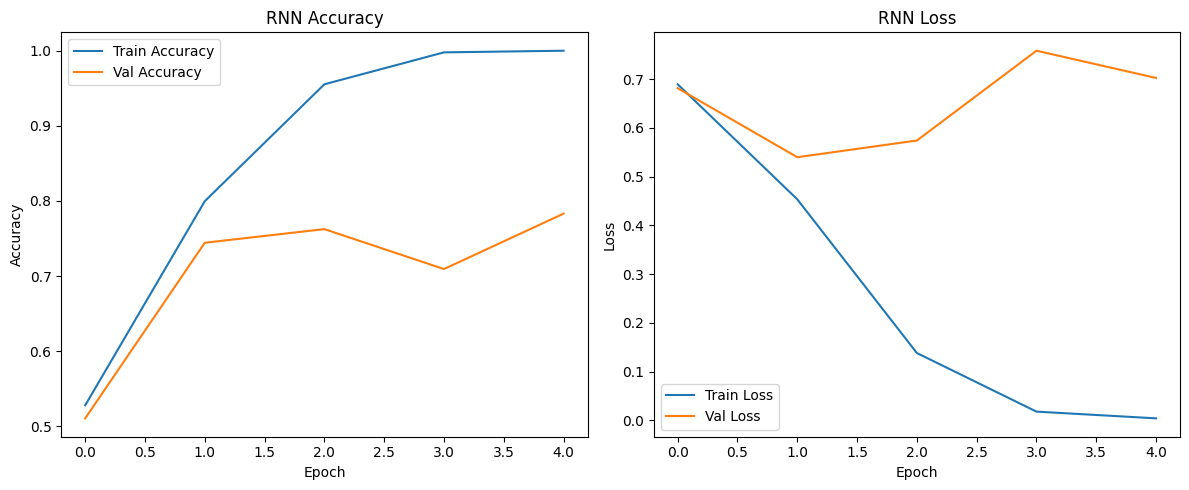

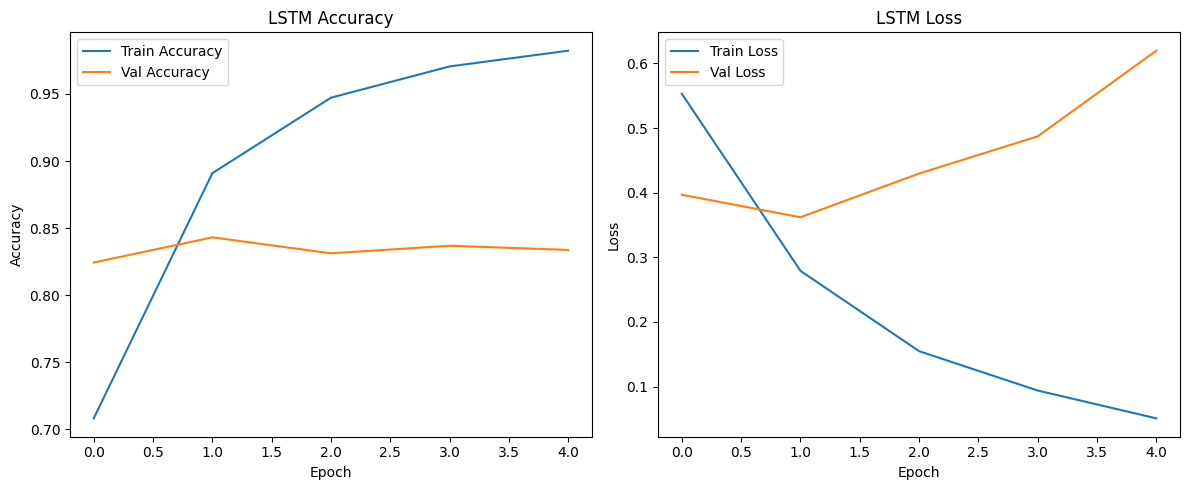

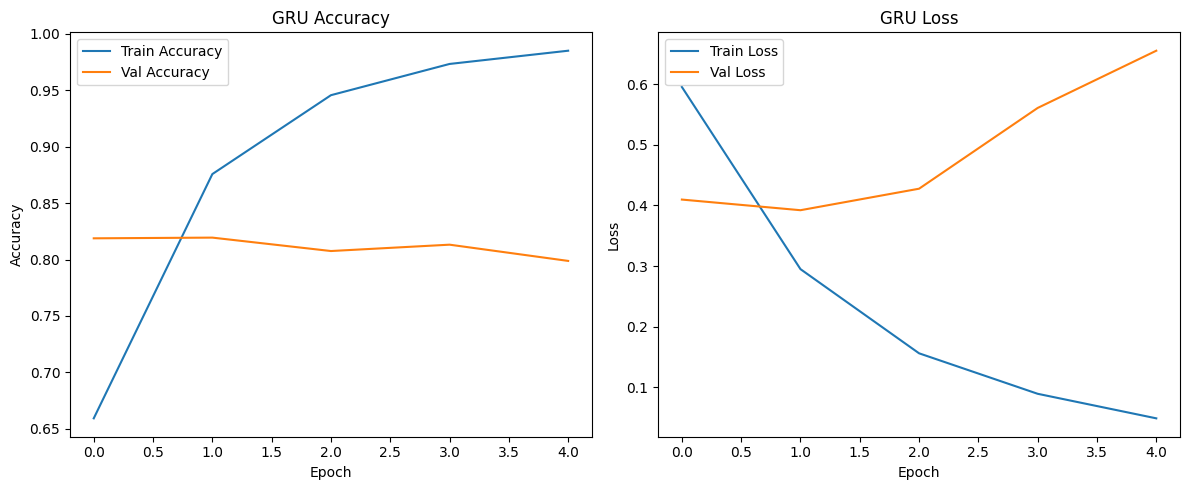

In [14]:
plot_history(rnn_history, 'RNN')
plot_history(lstm_history, 'LSTM')
plot_history(gru_history, 'GRU')


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


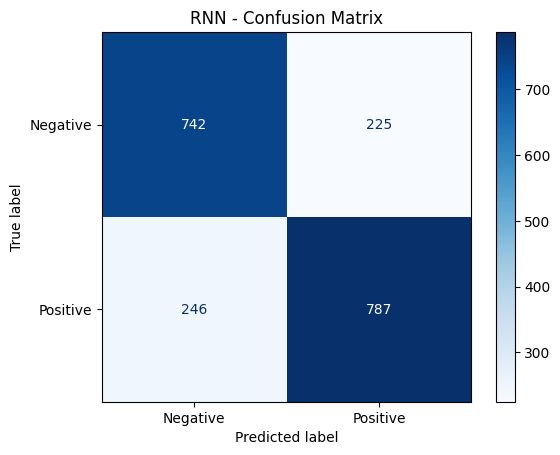

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


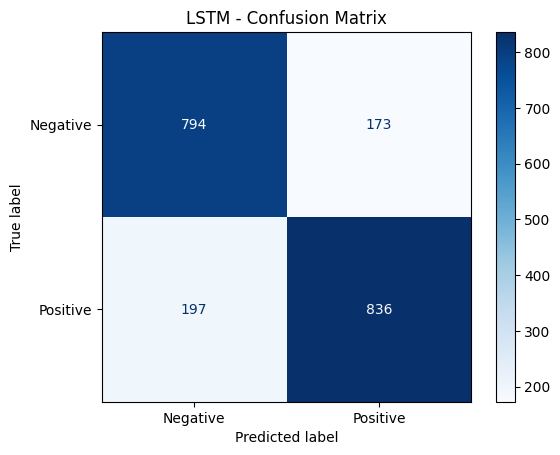

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


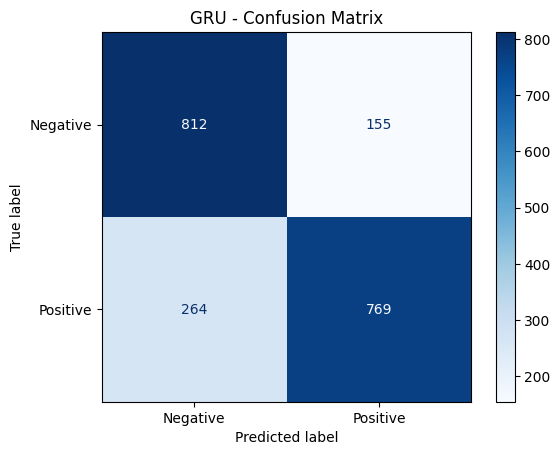

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def plot_conf_matrix(model, X_val, y_val, title):
    y_pred_prob = model.predict(X_val)
    y_pred = (y_pred_prob > 0.5).astype("int32")
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap="Blues")
    plt.title(f"{title} - Confusion Matrix")
    plt.show()

# Confusion matrix for each model
plot_conf_matrix(rnn_model, X_val, y_val, "RNN")
plot_conf_matrix(lstm_model, X_val, y_val, "LSTM")
plot_conf_matrix(gru_model, X_val, y_val, "GRU")



# Model Testing

In [16]:

def predict_sentiment(model, tokenizer, sentence, max_len):
    sequence = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    pred = model.predict(padded)[0][0]
    sentiment = "Positive" if pred > 0.5 else "Negative"
    return sentiment, round(float(pred), 3)  

sample = "Movie is ok ok"
max_length = X_train.shape[1]  
predict_sentiment(lstm_model, tokenizer, sample, max_length)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


('Negative', 0.249)

In [17]:


samples = [
    "I absolutely loved this movie!",
    "It was boring and too long.",
    "Just an average film, nothing special.",
    "The acting was incredible and touching.",
    "Worst plot I have ever seen."
]

for s in samples:
    print("Sentence:", s)
    print("Prediction (LSTM):", predict_sentiment(lstm_model, tokenizer, s, max_length))
    print("Prediction (GRU):", predict_sentiment(gru_model, tokenizer, s, max_length))
    print("Prediction (RNN):", predict_sentiment(rnn_model, tokenizer, s, max_length))
    print("-----")




Sentence: I absolutely loved this movie!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction (LSTM): ('Negative', 0.249)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction (GRU): ('Positive', 0.988)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction (RNN): ('Positive', 0.999)
-----
Sentence: It was boring and too long.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction (LSTM): ('Negative', 0.249)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction (GRU): ('Positive', 0.988)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction (RNN): ('Positive', 0.999)
-----
Sentence: Just an average film, nothing special.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction (LSTM): ('Negative', 0.249)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction (GRU): ('Positive', 0.988)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction (RNN): ('Positive', 0.999)
-----
Sentence: The acting was incredible and touching.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction (LSTM): ('Negative', 0.249)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Pr